This file contains BME630: Multiclass Classification of Alzheimer.

MRI images from datasets are used to classify the image as per stages of AD as follows:
1. Class - 1: Non Demented (3200 images)
2. Class - 2: Very Mild Demented (2240 images)
3. Class - 3: Mild Demented (896 images)
4. Class - 4: Moderate Demented (64 images)

The data is derived from a kaggle dataset: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

The following methods are used:
 - Random forest
 - Perceptrom
 - CNN
 - SVC

This code is meant to be run on Colab. Modifications may be need to be made to run it locally.

by
Rintaro Masuda,
Arushi Tandon

In [ ]:
# Imports needed for this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Note that if you are using Anaconda, GraphViz won't be installed by default.
# You will need to install graphviz and python-graphviz.
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, roc_curve, auc
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Set up the environment and upload the data
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep
from tqdm.notebook import tqdm
import os
sns.set()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

import tarfile
import zipfile
from pathlib import Path

import pandas as pd
import io
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# This code will download the required data files from GitHub
import requests
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'ArushiTand'
    repo = 'ML-Project'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Dataset.zip', 'temp/Dataset.zip')

In [ ]:
# Unzip the file
if not os.path.exists('temp/Dataset'):
  !pip install patool
  import patoolib
  patoolib.extract_archive('temp/Dataset.zip', outdir='temp/')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 3.4 MB/s eta 0:00:00


INFO patool: Extracting temp/Dataset.zip ...
INFO:patool:Extracting temp/Dataset.zip ...
INFO patool: running /usr/bin/7z x -otemp/ -- temp/Dataset.zip
INFO:patool:running /usr/bin/7z x -otemp/ -- temp/Dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... temp/Dataset.zip extracted to `temp/'.
INFO:patool:... temp/Dataset.zip extracted to `temp/'.


In [ ]:
# Get data
data_dir = Path('/content/temp/Dataset/')
#class_names = sorted([p.stem for p in data_dir.iterdir() if p.is_dir()])

# Choose image files from the four classes below
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
image_files = [[x for x in (data_dir / class_name).iterdir()] for class_name in class_names]

mild_demented = [x for x in (data_dir / class_names[0]).iterdir()]
moderate_demented = [x for x in (data_dir / class_names[1]).iterdir()]
non_demented = [x for x in (data_dir / class_names[2]).iterdir()]
very_mild_demented = [x for x in (data_dir / class_names[3]).iterdir()]

Each variable contains the directory of each sample

**EXPLORATORY DATA ANALYSIS**

/content/temp/Dataset/Non_Demented/non_1608.jpg
One of the data in Non Alzheimer Folder
Image shape:(128, 128)
<class 'numpy.ndarray'>
Class distribution:
 demented: 3200 
 	 mild:896 
 	 moderate:64 
  	 very_mild:2240 
 non demented:3200 


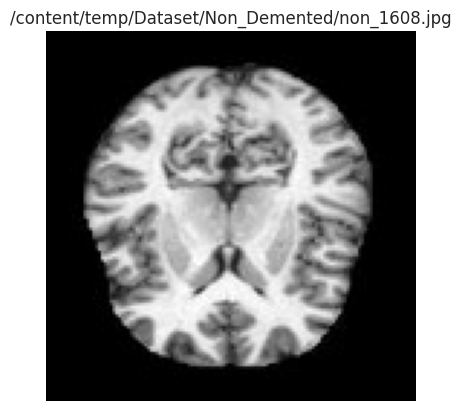

In [ ]:
print(non_demented[1])
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img,'gray')
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    print(type(img))
    return img

print('One of the data in Non Alzheimer Folder')
view_image(non_demented[1])

#Class distribution
mild = len(mild_demented)
moderate = len(moderate_demented)
non = len(non_demented)
very_mild = len(very_mild_demented)
demented = mild + moderate + very_mild
print(f'Class distribution:\n demented: {demented} \n \t mild:{mild} \n \t moderate:{moderate} \n  \t very_mild:{very_mild} \n non demented:{non} ')

From this we can see that the data is a 2 dimentional array in the shape of (128, 128).

Furthermore, it seems like there is quite the uneven split in regards to the class distribution.

Class distribution:
 mild:896
 moderate:64
 non:3200
 very_mild:2240  

 However the total split between demented and non demented are balanced. Therefore, we can use the dataset as it is with detection, however classification would require classification would require us to make sure the class weights are controlled for

# **Multiclass Classification**

**DATA PREPARATION FOR SEGMENTATION**

In [ ]:
def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  # normalize pixel values
    return img

non_ALZ = [extract_feature(filename) for filename in non_demented]
vmild_ALZ = [extract_feature(filename) for filename in very_mild_demented]
mild_ALZ = [extract_feature(filename) for filename in mild_demented]
moderate_ALZ = [extract_feature(filename) for filename in moderate_demented]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ
print(type(non_ALZ))

#Create Feature Matrix
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))

#split the data
from sklearn.model_selection import train_test_split
# Define labels for multi-class classification (0: non-Alzheimer's, 1: very mild, 2: mild, 3: moderate)
y = np.concatenate([
    np.zeros(len(non_ALZ)),
    np.ones(len(vmild_ALZ)),
    2 * np.ones(len(mild_ALZ)),
    3 * np.ones(len(moderate_ALZ))
])
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<class 'list'>


In [ ]:
#Evaluation Function
def EvaluateModel(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True)
    plt.gcf().set_size_inches(2, 2)
    plt.show()
    print('Classification report for training set:')
    print(classification_report(y_train, y_train_pred, zero_division=0.0))
    print('Classfication report for test set:')
    print(classification_report(y_test, y_test_pred, zero_division=0.0))

Preceptron Evaluation


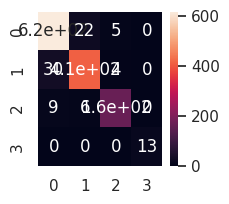

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2557
         1.0       0.99      0.99      0.99      1796
         2.0       1.00      0.99      0.99       716
         3.0       1.00      1.00      1.00        51

    accuracy                           0.99      5120
   macro avg       1.00      0.99      0.99      5120
weighted avg       0.99      0.99      0.99      5120

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       643
         1.0       0.94      0.92      0.93       444
         2.0       0.95      0.92      0.93       180
         3.0       1.00      1.00      1.00        13

    accuracy                           0.94      1280
   macro avg       0.96      0.95      0.95      1280
weighted avg       0.94      0.94      0.94      1280

[0.9390625  0.90703125 0.94140625 0.86015625 0.7578125 

In [ ]:
p_model = Perceptron(max_iter=100, eta0=0.2, random_state=0)
p_model.fit(X_train, y_train)

#Evaluate
print("Preceptron Evaluation")
EvaluateModel(p_model, X_train, X_test, y_train, y_test)

#Further evaluation with cross validation
cross_val = cross_val_score(p_model, all_data, y, cv=5)
print(f"Cross Validation Score {cross_val}")

Preceptron Evaluation with Scaled Features


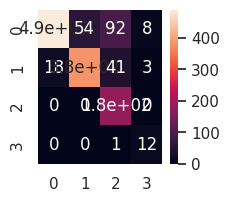

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89      2557
         1.0       0.92      0.93      0.92      1796
         2.0       0.64      1.00      0.78       716
         3.0       0.57      0.94      0.71        51

    accuracy                           0.88      5120
   macro avg       0.78      0.92      0.83      5120
weighted avg       0.91      0.88      0.88      5120

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85       643
         1.0       0.88      0.86      0.87       444
         2.0       0.57      1.00      0.73       180
         3.0       0.52      0.92      0.67        13

    accuracy                           0.83      1280
   macro avg       0.73      0.89      0.78      1280
weighted avg       0.87      0.83      0.84      1280



In [ ]:
print("Preceptron Evaluation with Scaled Features")
EvaluateModel(p_model, X_train_scaled, X_test_scaled, y_train, y_test)

**SVC**



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


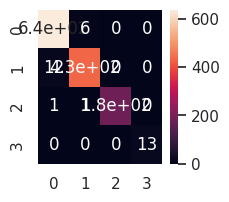

Classification report for training set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2557
         1.0       1.00      1.00      1.00      1796
         2.0       1.00      1.00      1.00       716
         3.0       1.00      1.00      1.00        51

    accuracy                           1.00      5120
   macro avg       1.00      1.00      1.00      5120
weighted avg       1.00      1.00      1.00      5120

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       643
         1.0       0.98      0.97      0.98       444
         2.0       1.00      0.99      0.99       180
         3.0       1.00      1.00      1.00        13

    accuracy                           0.98      1280
   macro avg       0.99      0.99      0.99      1280
weighted avg       0.98      0.98      0.98      1280



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([0.98359375, 0.97890625, 0.97890625, 0.984375  , 0.978125  ])

In [ ]:
linearsvc_model = LinearSVC( random_state=0)
linearsvc_model.fit(X_train, y_train)
linearsvc_pred = linearsvc_model.predict(X_test)

# Results
print("SVC Evaluation")
EvaluateModel(linearsvc_model, X_train, X_test, y_train, y_test)

print("SVC Cross Validation")
cross_val = cross_val_score(linearsvc_model, all_data, y, cv=5)
print(f"Cross Validation Score {cross_val}")

Preceptron Evaluation


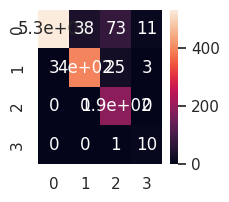

Classification report for training set:
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94      2545
         1.0       0.95      0.99      0.97      1813
         2.0       0.77      1.00      0.87       709
         3.0       0.69      1.00      0.82        53

    accuracy                           0.94      5120
   macro avg       0.85      0.97      0.90      5120
weighted avg       0.95      0.94      0.94      5120

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.90       655
         1.0       0.91      0.93      0.92       427
         2.0       0.65      1.00      0.79       187
         3.0       0.42      0.91      0.57        11

    accuracy                           0.88      1280
   macro avg       0.74      0.91      0.79      1280
weighted avg       0.91      0.88      0.89      1280



In [ ]:
print("SVC Evaluation with Standardized Dataset")
EvaluateModel(linearsvc_model, X_train_scaled, X_test_scaled, y_train, y_test)

**RANDOM FORREST**

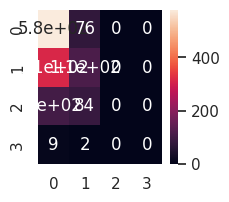

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.58      0.90      0.71      2545
         1.0       0.48      0.32      0.38      1813
         2.0       0.00      0.00      0.00       709
         3.0       0.00      0.00      0.00        53

    accuracy                           0.56      5120
   macro avg       0.26      0.30      0.27      5120
weighted avg       0.46      0.56      0.49      5120

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.58      0.88      0.70       655
         1.0       0.41      0.27      0.32       427
         2.0       0.00      0.00      0.00       187
         3.0       0.00      0.00      0.00        11

    accuracy                           0.54      1280
   macro avg       0.25      0.29      0.26      1280
weighted avg       0.43      0.54      0.47      1280



In [ ]:
forest_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
forest_model.fit(X_train, y_train)
print("Random Forest Evaluation")
EvaluateModel(forest_model, X_train, X_test, y_train, y_test)

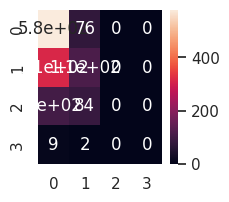

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.58      0.90      0.71      2545
         1.0       0.48      0.32      0.38      1813
         2.0       0.00      0.00      0.00       709
         3.0       0.00      0.00      0.00        53

    accuracy                           0.56      5120
   macro avg       0.26      0.30      0.27      5120
weighted avg       0.46      0.56      0.49      5120

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.58      0.88      0.70       655
         1.0       0.41      0.27      0.32       427
         2.0       0.00      0.00      0.00       187
         3.0       0.00      0.00      0.00        11

    accuracy                           0.54      1280
   macro avg       0.25      0.29      0.26      1280
weighted avg       0.43      0.54      0.47      1280



In [ ]:
#Random forest with scaled values

forest_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
forest_model.fit(X_train_scaled, y_train)
print("Random Forest Evaluation with Standadized Data")
EvaluateModel(forest_model, X_train_scaled, X_test_scaled, y_train, y_test)

**CNN**

In [ ]:
# This will allow the network to run on GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
print(device)

cuda


In [ ]:
mild_demented = [x for x in (data_dir / class_names[0]).iterdir()]
moderate_demented = [x for x in (data_dir / class_names[1]).iterdir()]
non_demented = [x for x in (data_dir / class_names[2]).iterdir()]
very_mild_demented = [x for x in (data_dir / class_names[3]).iterdir()]

#split data
#mild_demented
size = len(mild_demented)
data = mild_demented
print(size)
training_mild = np.array(data[:round(0.8*size)])
validation_mild = np.array(data[round(0.8*size):round(0.9*size)])
test_mild = np.array(data[round(0.9*size):])

#moderate_demented
size = len(moderate_demented)
data = moderate_demented
print(size)
training_moderate = np.array(data[:round(0.8*size)])
validation_moderate= np.array(data[round(0.8*size):round(0.9*size)])
test_moderate = np.array(data[round(0.9*size):])

#non_demented
size = len(non_demented)
data = non_demented
print(size)
training_non = np.array(data[:round(0.8*size)])
validation_non = np.array(data[round(0.8*size):round(0.9*size)])
test_non = np.array(data[round(0.9*size):])

#very_mild_demented
size = len(very_mild_demented)
data = very_mild_demented
print(size)
training_vmild = np.array(data[:round(0.8*size)])
validation_vmild = np.array(data[round(0.8*size):round(0.9*size)])
test_vmild = np.array(data[round(0.9*size):])


train = (training_mild,training_moderate,training_non,training_vmild)
validate = (validation_mild,validation_moderate,validation_non,validation_vmild)
test = (test_mild,test_moderate,test_non,test_vmild)

#80% training set
dataset_train = np.concatenate(train)
print(dataset_train.shape)
#10% validation set
dataset_valid = np.concatenate(validate)
#10% test set
dataset_test = np.concatenate(test)

# Create a training / validation / testing split for the labels
#(0: non-Alzheimer's, 1: very mild, 2: mild, 3: moderate)
l_train = (np.array([2]*len(training_mild)), np.array([3]*len(training_moderate)),np.array([0]*len(training_non)),np.array([1]*len(training_vmild)))
l_valid = (np.array([2]*len(validation_mild)), np.array([3]*len(validation_moderate)),np.array([0]*len(validation_non)),np.array([1]*len(validation_vmild)))
l_test = (np.array([2]*len(test_mild)), np.array([3]*len(test_moderate)),np.array([0]*len(test_non)),np.array([1]*len(test_vmild)))
labels_train = np.concatenate(l_train)
labels_valid = np.concatenate(l_valid)
labels_test = np.concatenate(l_test)

print('train', len(dataset_train), len(labels_train))
print('valid', len(dataset_valid), len(labels_valid))
print('test ', len(dataset_test), len(labels_test))

896
64
3200
2240
(5120,)
train 5120 5120
valid 640 640
test  640 640


In [ ]:
print(dataset_train.shape)

(5120,)


In [ ]:
def convert_to_torch_tensor(dataset):
  ''' takes list of image paths and reads them into an array;
      converts to tensor '''
  image_list=[]

  for image_path in dataset:
    # Read in each jpeg and convert to array,
    image=np.array(Image.open(image_path))
    # Normalise into range 0-1
    if np.max(image)-np.min(image) !=0:
      image=(image-np.min(image))/(np.max(image)-np.min(image))


    # Read into list
    image_list.append(image)

  # Convert list to np array
  image_array=np.asarray(image_list)

  # Convert numpy array to torch tensor with added dimension corresponding to the number of channels (1)
  torch_tensor=torch.from_numpy(np.expand_dims(image_array,axis=1)).to(torch.float)
  return torch_tensor

# Create torch tensors for train, validation and test
# X_train=torch.from_numpy(dataset_train)
# X_valid=torch.from_numpy(dataset_valid)
# X_test=torch.from_numpy(dataset_test)

# print('train shape', X_train.shape)
# print('valid shape', X_valid.shape)
# print('test shape ', X_test.shape)
X_train=convert_to_torch_tensor(dataset_train)
X_valid=convert_to_torch_tensor(dataset_valid)
X_test=convert_to_torch_tensor(dataset_test)

print('train shape', X_train.shape)
print('valid shape', X_valid.shape)
print('test shape ', X_test.shape)

train shape torch.Size([5120, 1, 128, 128])
valid shape torch.Size([640, 1, 128, 128])
test shape  torch.Size([640, 1, 128, 128])


In [ ]:
# LABEL_MAPPING = {"": 0, "chest": 1, "head": 2, "abdomen": 3}

# def convert_labels(label_list):
#   ''' will loop throuhg all labels and convert to integers'''
#   label_ids=[]

#   for lb in label_list:
#     label_ids.append(LABEL_MAPPING[lb])

#   labels_tensor=torch.from_numpy(np.asarray(label_ids)).to(torch.long)

#   return labels_tensor

# Create torch tensors for train, validation and test
y_train=torch.from_numpy(labels_train)
y_valid=torch.from_numpy(labels_valid)
y_test=torch.from_numpy(labels_test)

print('train labels', y_train)

train labels tensor([2, 2, 2,  ..., 1, 1, 1])


In [ ]:
class MedNet(nn.Module):

    def __init__(self, flattened_dim):
        super(MedNet,self).__init__()

        # The syntax to define the convolutional layers is:
          # nn.Conv2d(channels in, channels out, filter size)

        # For layer 1:
                      # channels in = 1 (input has 1 channel - greyscale)
                      # channels out = 8 (hyperparameter - you can try different values here)
                      # the filter kernel size is 3
                      # padding is set to True (or same)
        self.conv1 = nn.Conv2d(1, 8, 3, padding='same')

        # For layer 2:
                      # channels in = 8 (equal to the output channel dimension of the previous layer)
                      # channels out = 16 (hyperparameter - you can try different values here)
        self.conv2 = nn.Conv2d(8, 16, 3, padding='same')

        # For layer 3:
                      # channels in = 16
                      # channels out = 32 (hyperparameter - you can try different values here)
        self.conv3 = nn.Conv2d(16, 32, 3, padding='same')

        # For layer 4:
                      # channels in = 32
                      # channels out = 48 (hyperparameter - you can try different values here)
        self.conv4 = nn.Conv2d(32, 48, 3, padding='same')

        # Max pooling kernel of size 2x2
        self.pool = nn.MaxPool2d(2, 2)

        # The syntax to define the linear layers is:
          # nn.Linear(nodes in, nodes out)

        # The first linear layer will have input dimensions equal to the length of the flattened output from conv2
        # The output dimensions are a hyperparameter - we choose 25
        self.ful1 = nn.Linear(flattened_dim, 25)

        # The second linear layer will have input dimensions equal to the output of the first linear layer
        # The output will be equal to the number of classes (here 4)
        self.ful2 = nn.Linear(25, 4)


    def forward(self,x):
        # Here we put the layers together, implementing ReLU activations after each weight learning layer
        # First convolutional layer followed by ReLU, then pooling:
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional layer + ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional layer + ReLU and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Fourth convolutional layer + ReLU and pooling
        x = self.pool(F.relu(self.conv4(x)))

        # The last activation map is flattened:
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # x is then passed through one linear layer with input dims equal to the flattened dims
        x = F.relu(self.ful1(x))

        # And a second linear layer with output dim equal to the number of classes
        x = self.ful2(x)

        return x


fc1_input_dim = 8*8*48  # Complete this line of code #

# Push the network to the device
net = MedNet(fc1_input_dim).to(device)

In [ ]:
loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device) # send to device

# Note the optimiser takes the network as an argument
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train loss : 1.3900, Val Loss: 1.3876, Val accuracy: 0.3500
Train loss : 1.3874, Val Loss: 1.3831, Val accuracy: 0.3500
Train loss : 1.3828, Val Loss: 1.3770, Val accuracy: 0.3500
Train loss : 1.3767, Val Loss: 1.3693, Val accuracy: 0.3500
Train loss : 1.3690, Val Loss: 1.3608, Val accuracy: 0.3500
Train loss : 1.3605, Val Loss: 1.3512, Val accuracy: 0.3500
Train loss : 1.3509, Val Loss: 1.3406, Val accuracy: 0.3500
Train loss : 1.3403, Val Loss: 1.3291, Val accuracy: 0.3500
Train loss : 1.3288, Val Loss: 1.3169, Val accuracy: 0.3500
Train loss : 1.3165, Val Loss: 1.3039, Val accuracy: 0.3500
Train loss : 1.3035, Val Loss: 1.2902, Val accuracy: 0.3500
Train loss : 1.2898, Val Loss: 1.2758, Val accuracy: 0.3500
Train loss : 1.2754, Val Loss: 1.2607, Val accuracy: 0.3500
Train loss : 1.2603, Val Loss: 1.2448, Val accuracy: 0.4828
Train loss : 1.2444, Val Loss: 1.2281, Val accuracy: 0.5000
Train loss : 1.2276, Val Loss: 1.2106, Val accuracy: 0.5000
Train loss : 1.2101, Val Loss: 1.1922, V

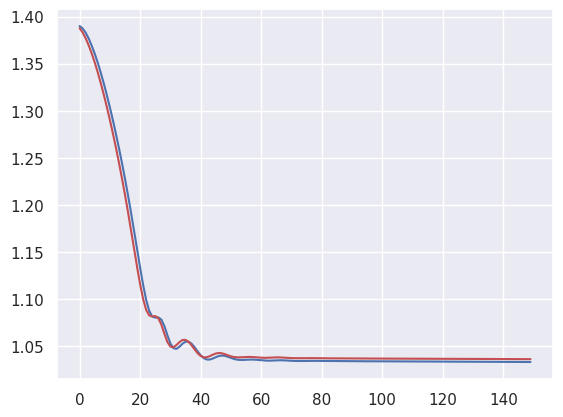

In [ ]:
from sklearn.metrics import accuracy_score

epochs = 150
accuracy = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Set network to training mode
    net.train()

    # Perform a training loop
    data = X_train.to(device)
    label = y_train.to(device)

    # Clear the gradients
    optimizer.zero_grad()

    # Feed the input and acquire the output from network
    x_out = net(data)

    # Calculate the loss
    err = loss_fun(x_out, label)
    train_losses.append(err)

    # Compute the gradient
    err.backward()

    # Update the parameters
    optimizer.step()

    with torch.no_grad():
      net.eval()

      valdata = X_valid.to(device)
      vallabel = y_valid.to(device)
      x_out = net(valdata)
      val_err = loss_fun(x_out, vallabel)
      val_losses.append(val_err)
      pred = x_out.data.max(1)[1].cpu() # Get the index of the max log-probability
      accuracy.append(accuracy_score(y_valid, pred))

      print('Train loss : {:.4f}, Val Loss: {:.4f}, Val accuracy: {:.4f}'.format(err, val_err,accuracy[-1]))

print(['Best val error: ', np.min(accuracy)])

# This step is needed to manipulate lists of tensors from the gpu device locally with numpy.
# Try printing train_losses and val_losses before this step to understand why that's needed.
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
val_losses = [vl.cpu().detach().numpy() for vl in val_losses]

# Plot the losses
plt.plot(np.arange(len(train_losses)),train_losses,'b')
plt.plot(np.arange(len(train_losses)),val_losses,'r')
plt.show()

test accuracy 0.5


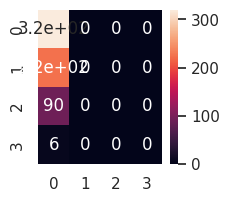

Classfication report for test set:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       320
           1       0.00      0.00      0.00       224
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00         6

    accuracy                           0.50       640
   macro avg       0.12      0.25      0.17       640
weighted avg       0.25      0.50      0.33       640



In [ ]:
net.eval()

testdata = X_test.to(device)
testlabel = y_test.to(device)
x_out = net(testdata)

pred = x_out.data.max(1)[1].cpu() # Get the index of the max log-probability
print('test accuracy', accuracy_score(y_test, pred))

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True)
plt.gcf().set_size_inches(2, 2)
plt.show()
print('Classfication report for test set:')
print(classification_report(y_test, pred, zero_division=0.0))